In [1]:
from skimage import color, data, io, filters, \
    transform, restoration, measure, segmentation
import matplotlib.pyplot as plt
import numpy as np

def show_image(image, title='Image', cmap_type='gray'):
    plt.figure(figsize=(8, 12))
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_comparison(original, filtered, title_filtered):
    fig, (ax1, ax2) = \
        plt.subplots(ncols=2, figsize=(16, 12), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(title_filtered)
    ax2.axis('off')

def show_image_contour(image, contours):
    fig, ax = plt.subplots()
    ax.imshow(image, cmap=plt.cm.gray)

    for n, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

## 1. Edges

In this exercise you will identify the shapes in a grapefruit image by detecting the edges, using the Canny algorithm.

![Grapefruits](images/1.jpg)

In [2]:
grape = io.imread('images/1.jpg', as_gray=True)

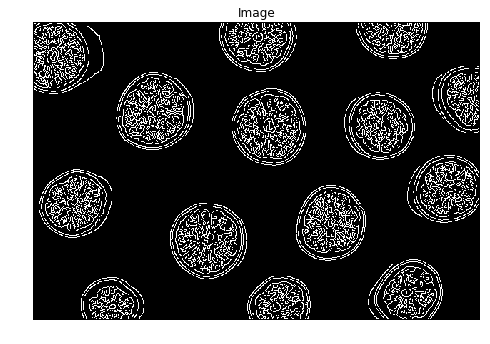

In [3]:
from skimage import feature
canny_edges = feature.canny(grape)
show_image(canny_edges)

## 2. Less edgy

Let's now try to spot just the outer shape of the grapefruits, the circles. You can do this by applying a more intense Gaussian filter to first make the image smoother. This can be achieved by specifying a bigger sigma in the canny function.

In this exercise, you'll experiment with sigma values of the `canny()` function.

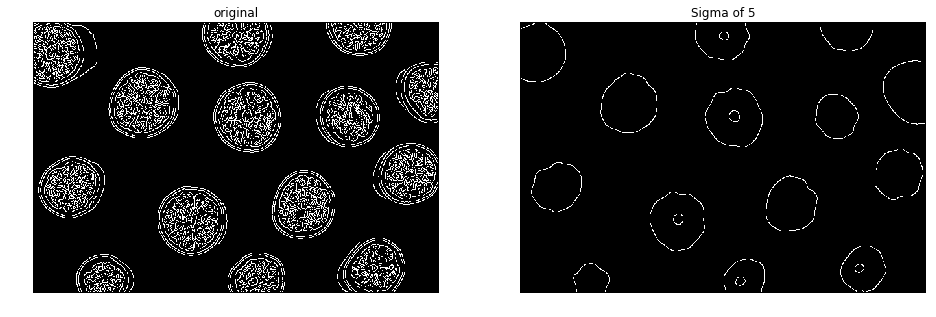

In [4]:
canny_edges_5 = feature.canny(grape, sigma=5)
plot_comparison(canny_edges, canny_edges_5, 'Sigma of 5')

## 3. Perspective

In this exercise, you will detect the corners of a building using the Harris corner detector.

![Building from a bottom perspective](images/3.jpg)

In [5]:
building = io.imread('images/3.jpg', as_gray=True)

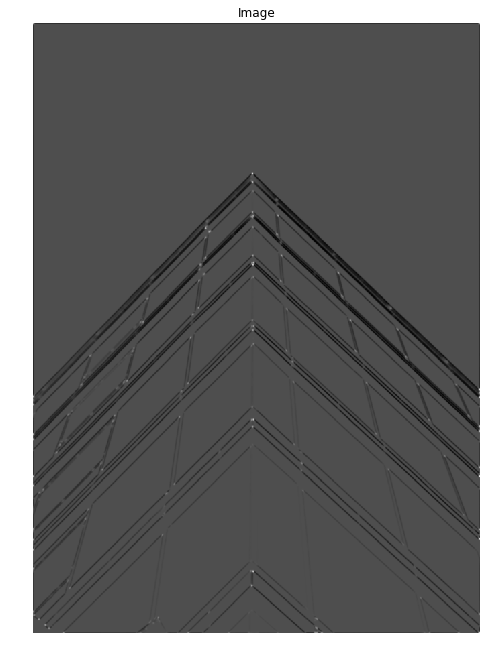

In [6]:
measure_image = feature.corner_harris(building)
show_image(measure_image)

In [7]:
def show_image_with_corners(image, coords, title="Corners detected"):
    plt.figure(figsize=(8, 12))
    plt.imshow(image, interpolation='nearest', cmap='gray')
    plt.title(title)
    plt.plot(coords[:, 1], coords[:, 0], '+r', markersize=15)
    plt.axis('off')
    plt.show()

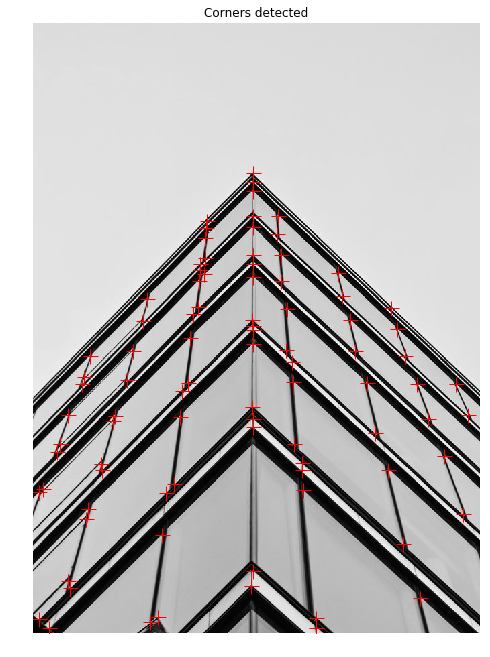

In [8]:
coords = feature.corner_peaks(measure_image, min_distance=5)
show_image_with_corners(building, coords)

## 4. Less corners

In this exercise, you will test what happens when you set the minimum distance between corner peaks to be a higher number. Remember you do this with the `min_distance` attribute parameter of the `corner_peaks()` function.

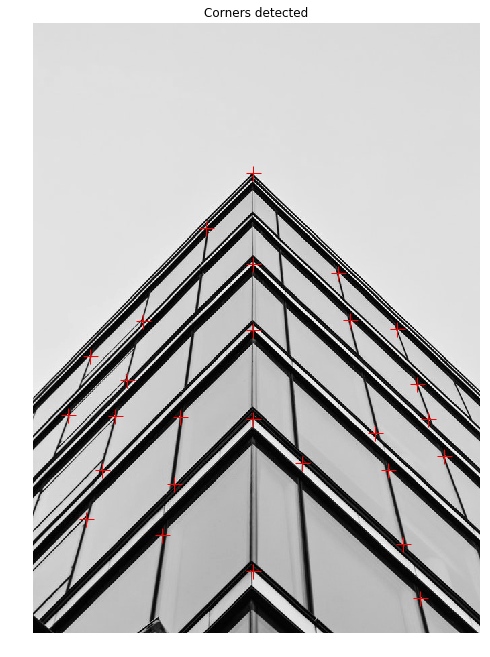

In [9]:
coords = feature.corner_peaks(measure_image, min_distance=50)
show_image_with_corners(building, coords)

## 5. Is someone there?

In this exercise, you will check whether or not there is a person present in an image taken at night.

![Landscape of starry night with a young man in the left bottom corner](images/5.jpg)

In [10]:
starry = io.imread('images/5.jpg')

In [11]:
trained_file = data.lbp_frontal_face_cascade_filename()
detector = feature.Cascade(trained_file)
detected = detector.detect_multi_scale(
    img=starry,
    scale_factor=1.2,
    step_ratio=1,
    min_size=(10, 10),
    max_size=(200, 200)
)

In [12]:
from matplotlib import patches

def show_detected_face(result, detected, title="Face image"):
    plt.figure(figsize=(8, 12))
    plt.imshow(result)
    img_desc = plt.gca()
    plt.set_cmap('gray')
    plt.title(title)
    plt.axis('off')

    for patch in detected:
        img_desc.add_patch(
            patches.Rectangle(
                (patch['c'], patch['r']),
                patch['width'],
                patch['height'],
                fill=False,color='r',linewidth=2
            )
        )

    plt.show()

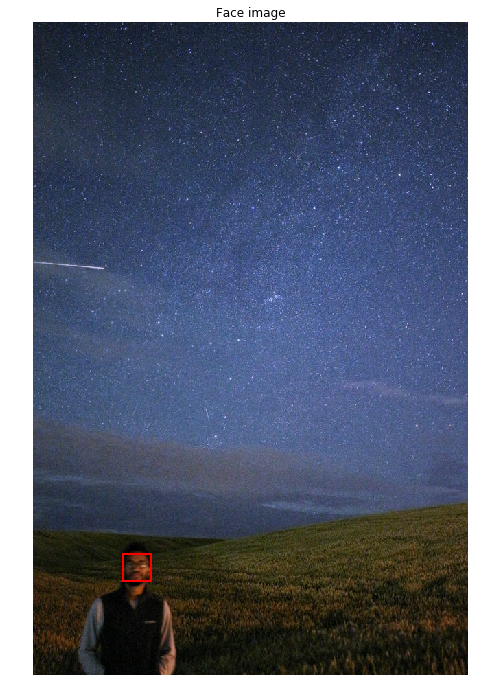

In [13]:
show_detected_face(starry, detected)

## 6. Multiple faces

In this exercise, you will detect multiple faces in an image and show them individually. Think of this as a way to create a dataset of your own friends' faces!

![A group of 7 friends](images/6.jpg)

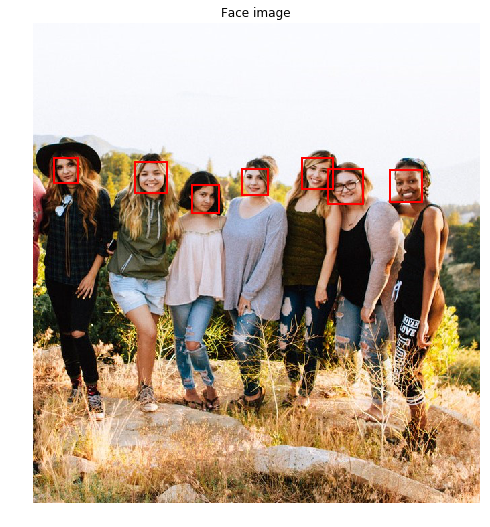

In [14]:
magnificient_seven = io.imread('images/6.jpg')
detected = detector.detect_multi_scale(
    img=magnificient_seven,
    scale_factor=1.2,
    step_ratio=1,
    min_size=(10, 10),
    max_size=(200, 200)
)
show_detected_face(magnificient_seven, detected)

## 7. Segmentation and face detection

Previously, you learned how to make processes more computationally efficient with unsupervised superpixel segmentation. In this exercise, you'll do just that!

Using the `slic()` function for segmentation, pre-process the image before passing it to the face detector.

![Young woman selfie](images/7.jpg)

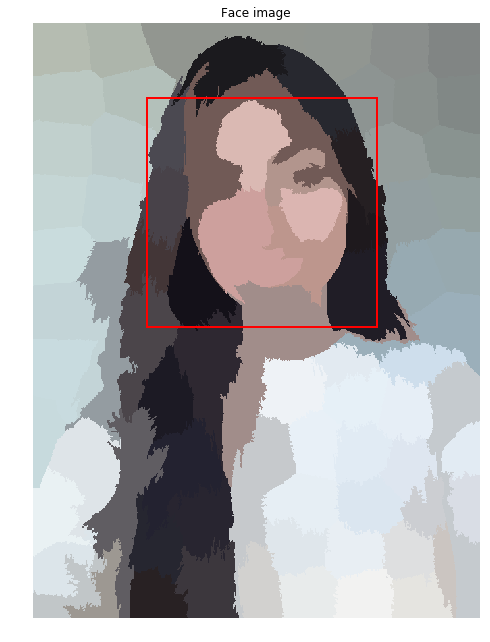

In [15]:
selfie = io.imread('images/7.jpg')
segments = segmentation.slic(selfie, n_segments=100)
segmented_selfie = color.label2rgb(segments, selfie, kind='avg')
detected = detector.detect_multi_scale(
    img=segmented_selfie,
    scale_factor=1.2,
    step_ratio=1, 
    min_size=(10, 10),
    max_size=(1000, 1000)
)
show_detected_face(segmented_selfie, detected)

## 8. Privacy protection

Let's look at a real-world application of what you have learned in the course.

In this exercise, you will detect **human** faces in the image and for the sake of privacy, you will anonymize data by blurring people's faces in the image automatically.

![Group band walking](images/8.jpg)

In [16]:
band = io.imread('images/8.jpg')

In [17]:
def get_face(image, detected_face):
    x_from, y_from = detected_face['r'], detected_face['c']
    x_to = x_from + detected_face['width']
    y_to = y_from + detected_face['height']
    face = image[x_from:x_to, y_from:y_to]
    return face

In [18]:
def merge_blurry_face(original, detected_face, gaussian_face):
    x_from, y_from = detected_face['r'], detected_face['c']
    x_to = x_from + detected_face['width']
    y_to = y_from + detected_face['height']
    original[x_from:x_to, y_from:y_to] = 255 * gaussian_face
    return original

In [19]:
detected = detector.detect_multi_scale(
    img=band,
    scale_factor=1.2,
    step_ratio=1, 
    min_size=(50, 50),
    max_size=(100, 100)
)

In [20]:
for detected_face in detected:
    face = get_face(band, detected_face)
    blurred_face = filters.gaussian(face, multichannel=True, sigma=10)
    resulting_image = merge_blurry_face(band, detected_face, blurred_face)

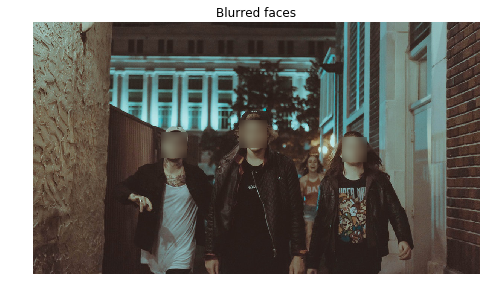

In [21]:
show_image(resulting_image, "Blurred faces")

## 9. Help Sally restore her graduation photo

You are going to combine all the knowledge you acquired throughout the course to complete a final challenge: reconstructing a very damaged photo.

Help Sally restore her favorite portrait which was damaged by noise, distortion, and missing information due to a breach in her laptop.

![Sally damaged picture](images/9.jpg)

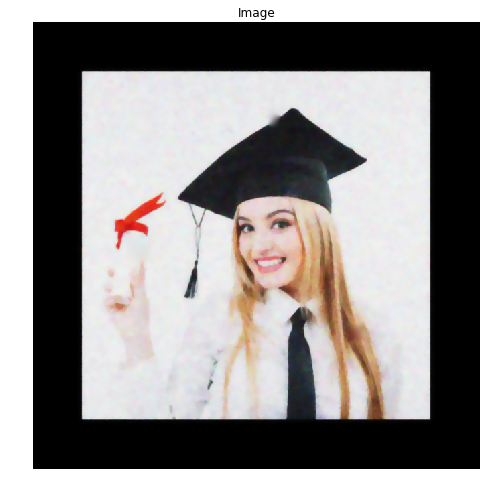

In [22]:
damaged_image = io.imread('images/9.jpg')
upright_img = transform.rotate(damaged_image, 20)
upright_img_without_noise = \
    restoration.denoise_tv_chambolle(upright_img, weight=.1, multichannel=True)
mask = np.zeros((upright_img.shape[0], upright_img.shape[1]))
mask[320:360,140:175] = 1
mask[130:160,350:370] = 1
mask[450:475,470:495] = 1
result = restoration.inpaint.inpaint_biharmonic(
    upright_img_without_noise, mask, multichannel=True)
show_image(result)